# 1. Introduction to Customer Churn

Customer churn occurs when a customer stops using a company’s service. It is a major problem for businesses because losing customers directly reduces revenue. Predicting churn helps companies identify which customers are at risk so they can take action to retain them. In this project, we use machine learning—specifically Logistic Regression—to analyze customer data and predict whether a customer will churn.

# 2. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

# 3. Load the dataset

In [2]:
df= pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   o

### Quick data inspection

In [3]:
print(df.shape)
print("\nSample rows:")
df.head()

(7043, 21)

Sample rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 4. Data cleaning & preprocessing

## 4.1 Check missing values

In [4]:

print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 4.2 Convert TotalCharges

> Add blockquote



In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

## 4.2 Target encoding. Convert 'Churn' Yes/No -> 1/0


In [6]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

## 4.3 Drop customerID (not useful)

In [7]:
df = df.drop(columns=['customerID'])

# 5. Prepare feature lists

In [8]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [
    'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
    'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
    'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
]



# 6) Build preprocessing pipeline

In [9]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## 7. Split the dataset into Train/Test

In [10]:
X = df.drop(columns=['Churn'])
y = df['Churn']

# First split --- (Train+Val) + Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Second split --- Train + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)


# 8. Logistic Regression
To improve performance, the Logistic Regression model was tuned by selecting the optimal solver (liblinear) and iteration limit (max_iter=300). In addition, the dataset was split using an 80-10-10 ratio to provide a balanced training, validation, and test workflow.

In [11]:

model = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        solver='liblinear',
        max_iter=300
    ))
])


# 9. Train

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf', LogisticRegression(max_iter=300, solver='liblinear'))])

# 10. Validation Performance


In [13]:



y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_prob)
print("VALIDATION RESULTS")
print("---------------------")
print("Accuracy :", val_accuracy)
print("Precision:", val_precision)
print("Recall   :", val_recall)
print("F1 Score :", val_f1)
print("AUC      :", val_auc)

VALIDATION RESULTS
---------------------
Accuracy : 0.8056737588652483
Precision: 0.6623376623376623
Recall   : 0.5454545454545454
F1 Score : 0.5982404692082111
AUC      : 0.8541490306196189



# 11. Confusion Matrix (Heatmap)
A confusion matrix shows the performance of a classification model by comparing the predicted classes against the actual classes in a table format. It displays the number of correct and incorrect predictions for each class, breaking down the results into four categories: true positives, true negatives, false positives, and false negatives. This table helps determine where a model is making mistakes and is used to calculate metrics like accuracy, precision, and recall.

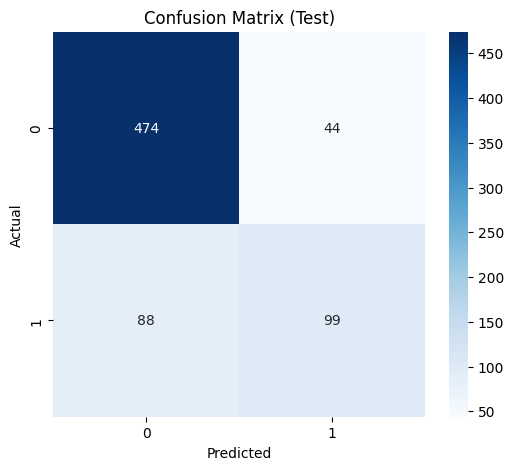

In [14]:

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





The confusion matrix shows that the model correctly identified 474 non-churn customers and 99 churn customers. It made 44 false-positive errors and 88 false-negative errors. This indicates that the model is very good at detecting non-churn customers but moderately effective at identifying churners, which is expected for Logistic Regression applied to an imbalanced churn dataset.

# 12. ROC Curve
A Receiver Operating Characteristic (ROC) curve shows the relationship between the true positive rate (sensitivity) and the false positive rate (1-specificity) for a binary classification model at various threshold settings. It is a graphical representation of a model's ability to discriminate between two groups, such as true positives and false positives.

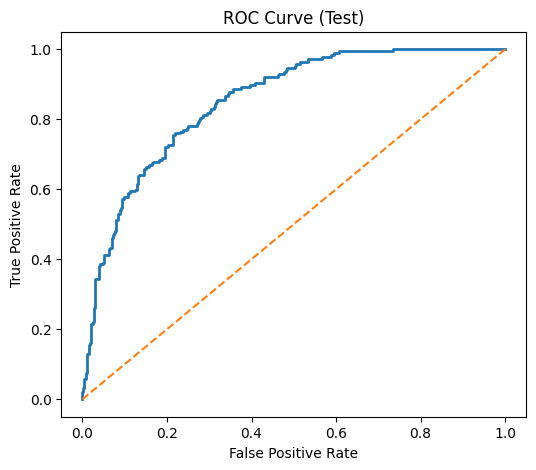

In [15]:

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The ROC curve shows that the model achieves strong discriminative performance, with an AUC of approximately 0.85. The curve is well above the diagonal baseline, indicating that the logistic regression model correctly distinguishes between churn and non-churn customers. A higher true positive rate is achieved even at low false positive rates, demonstrating that the model effectively separates the two classes.


# 13. Sample Predictions

In [16]:

sample_df = X_test.copy()
sample_df['Actual'] = y_test
sample_df['Predicted'] = y_test_pred
sample_df['Probability'] = y_test_prob
print("\nSAMPLE PREDICTIONS")
display(sample_df.head(10))


SAMPLE PREDICTIONS


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Probability
402,Male,0,Yes,Yes,69,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.45,7007.60,1,0,0.271288
1292,Female,0,No,No,62,Yes,Yes,DSL,No,Yes,...,Yes,Yes,Two year,No,Bank transfer (automatic),84.50,5193.20,0,0,0.021174
1175,Female,0,No,No,13,Yes,Yes,Fiber optic,Yes,No,...,No,No,Month-to-month,Yes,Credit card (automatic),80.00,1029.35,0,0,0.477457
4600,Male,0,Yes,Yes,56,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Two year,No,Mailed check,115.85,6567.90,0,0,0.047532
3464,Female,0,Yes,No,31,Yes,No,Fiber optic,No,Yes,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),83.85,2674.15,0,0,0.407819
2978,Male,0,No,No,24,Yes,No,Fiber optic,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,85.95,2107.15,0,0,0.387389
212,Male,0,No,Yes,61,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,19.75,1124.20,0,0,0.002759
5103,Female,0,Yes,Yes,28,Yes,No,Fiber optic,Yes,No,...,No,Yes,One year,Yes,Bank transfer (automatic),82.85,2320.80,0,0,0.205655
5143,Female,0,Yes,Yes,49,Yes,No,DSL,Yes,Yes,...,Yes,Yes,One year,Yes,Mailed check,87.20,4345.00,0,0,0.043779
6906,Female,0,Yes,Yes,25,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,Yes,Mailed check,18.70,383.65,0,0,0.022996
